<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Notes/How_to_load_and_preprocess_an_image_dataset_in_three_ways_using_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import tensorflow_datasets as tfds
import os

### Download the flowers dataset
This is a dataset of several thousand photos of flowers. The flowers dataset contains 5 sub-directories, one per class:

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(fname='flower_photos', origin=dataset_url, untar=True)

228818944/228813984 [==============================] - 3s 0us/step


In [ ]:
# Path to the downloaded file

data_dir

'/root/.keras/datasets/flower_photos'

In [ ]:
import pathlib

data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

image counts 

In [ ]:
image_counts = len(list(data_dir.glob('*/*.jpg')))
image_counts

3670

Each directory contains images of that type of flower. Here are some roses:

In [ ]:
roses = list(data_dir.glob('roses/*.jpg'))
roses[:5]

[PosixPath('/root/.keras/datasets/flower_photos/roses/11102341464_508d558dfc_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/537625768_791e973b40.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/3872230296_6c477309f3_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/16545641666_2781e542a0_m.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/3663244576_97f595cf4a.jpg')]

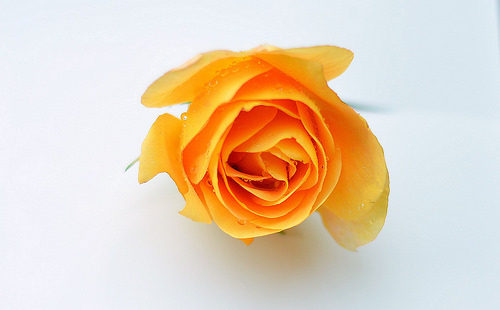

In [ ]:
# check an image
PIL.Image.open(str(roses[7]))

## Load using keras.preprocessing
Let's load these images off disk using `image_dataset_from_directory`.

#### Create a Dataset
Define some parameters for the loader
* batch-size
* height
* width

In [ ]:
# define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. We will use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                               batch_size=batch_size,
                                                               image_size=(img_width,img_height),
                                                               seed=42,
                                                               validation_split=.20,
                                                               subset='training')

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                                    batch_size=batch_size,
                                                                    image_size=(img_width,img_height),
                                                                    seed=42,
                                                                    validation_split=0.2,
                                                                    subset='validation')

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the class_names attribute on these datasets.

In [ ]:
train_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
val_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
class_names = train_ds.class_names

### Visualize the data

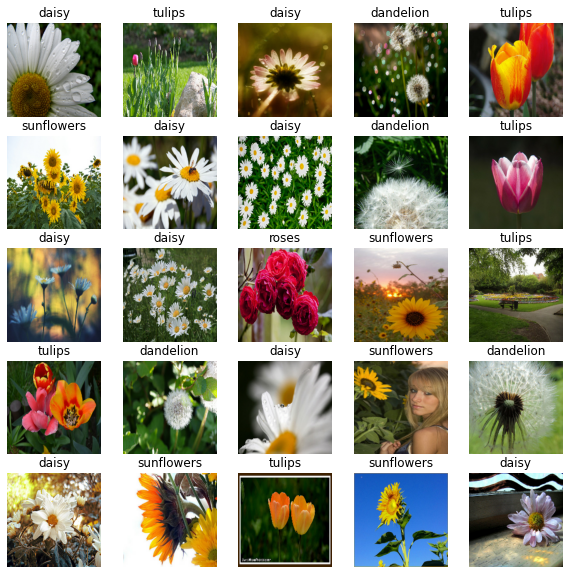

In [ ]:
plt.figure(figsize=(10,10))
for image, label in train_ds.take(1):
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(image[i].numpy().astype('uint8'));
    plt.title(class_names[label[i]])
    plt.axis(False)
plt.show();

You can train a model using these datasets by passing them to model.fit (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch , label_batch in train_ds:
  print(image_batch.shape)
  print(label_batch.shape)
  break


(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension referes to color channels RGB). The label_batch is a tensor of the shape (32,), these are the corresponding labels to the 32 images.

Note: you can call .numpy() on either of these tensors to convert them to a numpy.ndarray.

### Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer.

In [ ]:
from tensorflow.keras import layers


normalization_layer = layers.experimental.preprocessing.Rescaling(scale=1./255.)

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [ ]:
normalized_ds = train_ds.map(lambda x, y :(normalization_layer(x),y))

image_batch, label_batch = next(iter(normalized_ds))

first_image = image_batch[0]

print(' min : ',np.min(first_image),'\n max : ',np.max(first_image))

 min :  0.0 
 max :  1.0


Or, you can include the layer inside your model definition to simplify deployment. We will use the second approach here.

**Note:** If you would like to scale pixel values to [-1,1] you can instead write Rescaling(1./127.5, offset=-1)

**Note:** we previously resized images using the image_size argument of image_dataset_from_directory. If you want to include the resizing logic in your model, you can use the Resizing layer instead.

### Configure the dataset for performance
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Train a model

In [ ]:
# output class
num_class = len(class_names)
num_class

5

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255.),
                             tf.keras.layers.Conv2D(32,3,activation='relu', kernel_initializer='he_uniform', input_shape=(180, 180, 3)),
                             tf.keras.layers.MaxPool2D((3,3)),
                             tf.keras.layers.Conv2D(32,3,activation='relu', kernel_initializer='he_uniform'),
                             tf.keras.layers.MaxPool2D((3,3)),
                             tf.keras.layers.Conv2D(32,3,activation='relu', kernel_initializer='he_uniform'),
                             tf.keras.layers.MaxPool2D((3,3)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
                             tf.keras.layers.Dropout(rate=0.5),
                             tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
                             tf.keras.layers.Dense(num_class, activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history =  model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
92/92 [==============================] - 73s 775ms/step - loss: 1.5576 - accuracy: 0.3149 - val_loss: 1.1863 - val_accuracy: 0.4823
Epoch 2/5
92/92 [==============================] - 65s 703ms/step - loss: 1.2032 - accuracy: 0.5055 - val_loss: 1.0575 - val_accuracy: 0.5668
Epoch 3/5
92/92 [==============================] - 64s 698ms/step - loss: 1.0904 - accuracy: 0.5578 - val_loss: 0.9812 - val_accuracy: 0.5926
Epoch 4/5
92/92 [==============================] - 64s 696ms/step - loss: 0.9775 - accuracy: 0.6113 - val_loss: 0.9331 - val_accuracy: 0.6158
Epoch 5/5
92/92 [==============================] - 64s 697ms/step - loss: 0.9378 - accuracy: 0.6177 - val_loss: 0.9282 - val_accuracy: 0.6008


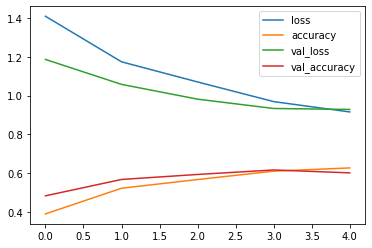

In [ ]:
# learning curve
pd.DataFrame(data=history.history).plot();

## Using tf.data for finer control
The above keras.preprocessing utilities are a convenient way to create a tf.data.Dataset from a directory of images. For finer grain control, you can write your own input pipeline using tf.data.

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(buffer_size=image_counts, seed=42, reshuffle_each_iteration=False)

In [ ]:
for l in list_ds.take(5):
  print(l)
  print(l.numpy())

tf.Tensor(b'/root/.keras/datasets/flower_photos/sunflowers/6140661443_bb48344226.jpg', shape=(), dtype=string)
b'/root/.keras/datasets/flower_photos/sunflowers/6140661443_bb48344226.jpg'
tf.Tensor(b'/root/.keras/datasets/flower_photos/sunflowers/16656015339_2ccb7cd18d.jpg', shape=(), dtype=string)
b'/root/.keras/datasets/flower_photos/sunflowers/16656015339_2ccb7cd18d.jpg'
tf.Tensor(b'/root/.keras/datasets/flower_photos/sunflowers/1788133737_b1133d1aa7.jpg', shape=(), dtype=string)
b'/root/.keras/datasets/flower_photos/sunflowers/1788133737_b1133d1aa7.jpg'
tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/8071646795_2fdc89ab7a_n.jpg', shape=(), dtype=string)
b'/root/.keras/datasets/flower_photos/daisy/8071646795_2fdc89ab7a_n.jpg'
tf.Tensor(b'/root/.keras/datasets/flower_photos/tulips/13509967925_eaaeefa396_m.jpg', shape=(), dtype=string)
b'/root/.keras/datasets/flower_photos/tulips/13509967925_eaaeefa396_m.jpg'


The tree structure of the files can be used to compile a class_names list.

In [ ]:
class_names = np.array(sorted([file.name for file in data_dir.glob('*') if file.name != 'LICENSE.txt']))
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

### Split data into train and validation set

In [ ]:
valid_size = int(0.2*image_counts)
train_ds = list_ds.skip(valid_size)
val_ds = list_ds.take(valid_size)

You can see the length of each dataset as follows:

In [ ]:
print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(train_ds).numpy())

tf.Tensor(2936, shape=(), dtype=int64)
2936


In [ ]:
print(tf.data.experimental.cardinality(val_ds))
print(tf.data.experimental.cardinality(val_ds).numpy())

tf.Tensor(734, shape=(), dtype=int64)
734


### Write a short function that converts a file path to an (img, label) pair:

In [ ]:

def get_label(filepath):
  #convert the path to a list of path components
  parts = tf.strings.split(filepath, sep=os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:

def decode_img(img):
  # convert the compressed string to a 3D uint tensor
  img = tf.image.decode_jpeg(img)
  # resize the image to the desired size
  return tf.image.resize(img, size=(img_height, img_width))

In [ ]:

def process_path(filepath):
  label = get_label(filepath)
  #  load the raw data from the file as a string
  raw_data = tf.io.read_file(filepath)
  img = decode_img(raw_data)
  return img, label

Use Dataset.map to create a dataset of image, label pairs:


 Set `num_parallel_calls` so multiple images are loaded/processed in parallel.

In [ ]:
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
  print('Image shape', image.shape)
  print('Label shape', label.shape)

  print('Label ', label.numpy())


Image shape (180, 180, 3)
Label shape ()
Label  2


### Configure dataset for performance
To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* To be cached
* To be prefetched

These features can be added using the tf.data API. 

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds



In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualize the data

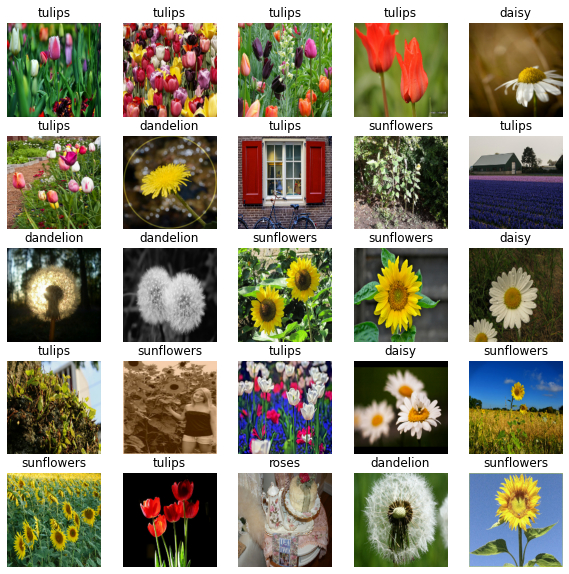

In [ ]:
### Visualize the data
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(image_batch[i].numpy().astype('uint8'))
  plt.axis(False)
  plt.title(class_names[label_batch[i].numpy()])
plt.show()

## Using TensorFlow Datasets

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load('tf_flowers',
                                                  split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                  with_info=True,
                                                  as_supervised=True
                                                  )

In [ ]:
# The flowers dataset has five classes.
num_classes = metadata.features['label'].num_classes
num_classes

5

In [ ]:
get_label_name = metadata.features['label'].int2str

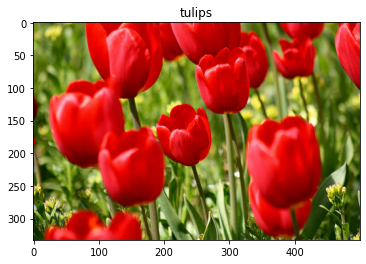

In [ ]:
image, label = next(iter(train_ds))
plt.imshow(image)
plt.title(get_label_name(label))
plt.show()

In [ ]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)